<a href="https://colab.research.google.com/github/kkalyagina/epam/blob/main/project_2month/notebook/project_2month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [1]:
! pip install -q kaggle

In [2]:
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kristinakaliagina","key":"5ff793b37d31620470c022da3799aa82"}'}

In [3]:
 ! mkdir ~/.kaggle

In [4]:
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-04-28 17:13:57           3855  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2230  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            482  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1417  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

In [13]:
! kaggle competitions download -c competitive-data-science-predict-future-sales

  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.88MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 2.45MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 77.0MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 57.0MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 57.6MB/s]
 68% 9.00M/13.3M [00:00<00:00, 31.4MB/s]
100% 13.3M/13.3M [00:00<00:00, 43.0MB/s]


In [14]:
! unzip items.csv.zip -d ./
! unzip sales_train.csv.zip -d ./
! unzip sample_submission.csv.zip -d ./
! unzip test.csv.zip -d ./

Archive:  items.csv.zip
  inflating: ./items.csv             
Archive:  sales_train.csv.zip
  inflating: ./sales_train.csv       
Archive:  sample_submission.csv.zip
  inflating: ./sample_submission.csv  
Archive:  test.csv.zip
  inflating: ./test.csv              


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import nbformat
from datetime import datetime, date
from sklearn.model_selection import TimeSeriesSplit
from collections import defaultdict
from itertools import product
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
import warnings
import itertools
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
from bokeh.io import output_notebook
output_notebook()

# Download dataset

In [16]:
sales = pd.read_csv("sales_train.csv")
items = pd.read_csv("./items.csv")
categories = pd.read_csv("./item_categories.csv")
shops = pd.read_csv("./shops.csv")
test = pd.read_csv("./test.csv")

# Sales:

date - date in format dd/mm/yyyy

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_price - current price of an item

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

# Items:

item_name - name of item

item_id - unique identifier of a product

item_category_id - unique identifier of item category

# Categories:

item_category_name - name of item category

item_category_id


# Shops:

shop_name - name of shop

shop_id - unique identifier of a shop

In [ ]:
cat_graph=categories.copy(deep=True)
cat_graph['item_category']=cat_graph['item_category_name'].str.split('-')
cat_graph['category']=cat_graph['item_category'].apply(lambda x: x[0].strip())
cat_graph['item'] = cat_graph['item_category'].apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cat_graph.drop(['item_category_name','item_category'], inplace=True, axis=1)

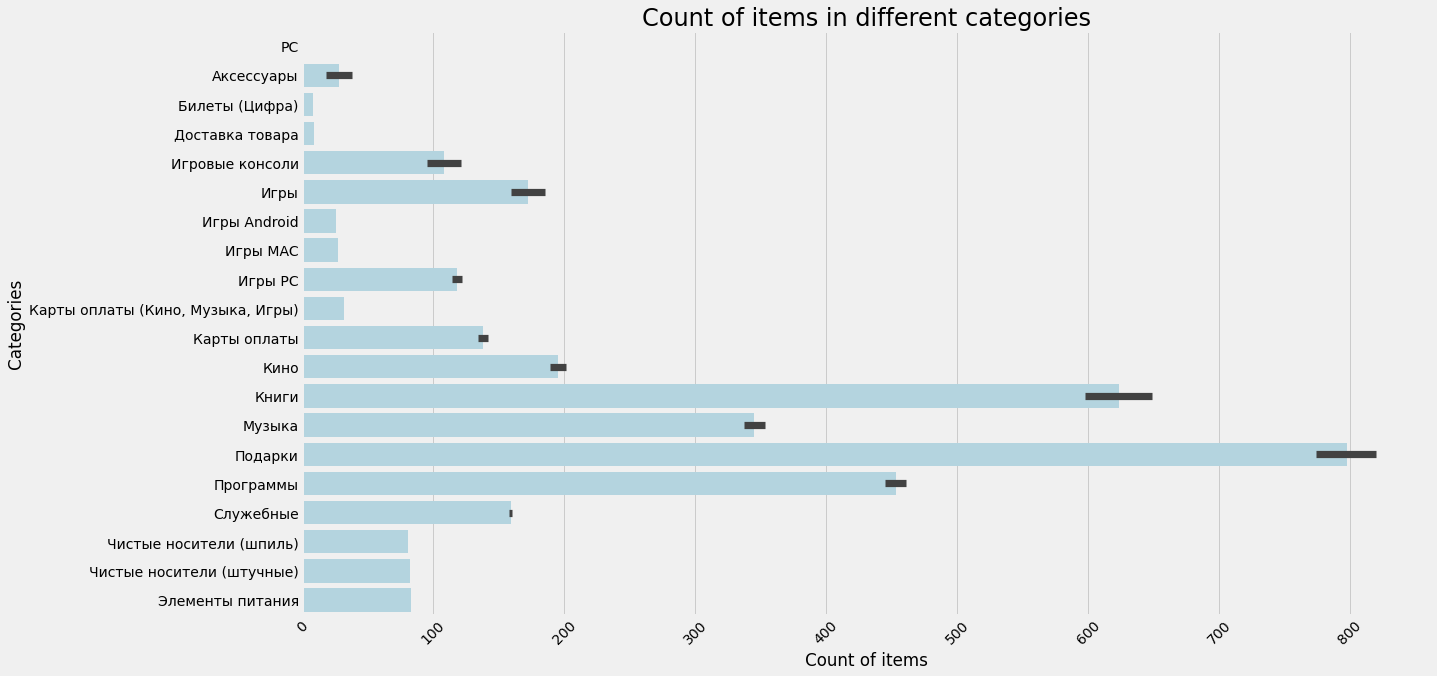

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Count of items in different categories', fontsize=24)
ax = sns.barplot(x='item_category_id', y='category', data=cat_graph, estimator=np.sum, color='lightblue')
ax = ax.set(xlabel='Count of items', ylabel='Categories')
plt.xticks(rotation=45)
plt.show() 

# To merge datasets

In [17]:
train = pd.merge(sales,
                    items[["item_id", "item_category_id"]],
                    how="inner",
                    on="item_id")

train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

test = pd.merge(test,
                   items[["item_id", "item_category_id"]],
                   how="inner",
                   on="item_id")

test["date_block_num"] = 34

In [ ]:
train

date  date_block_num  ...  item_cnt_day  item_category_id
0       2013-01-02               0  ...           1.0                37
1       2013-01-23               0  ...           1.0                37
2       2013-01-20               0  ...           1.0                37
3       2013-01-02               0  ...           1.0                37
4       2013-01-03               0  ...           1.0                37
...            ...             ...  ...           ...               ...
2935844 2015-10-17              33  ...           1.0                40
2935845 2015-10-01              33  ...           1.0                15
2935846 2015-10-29              33  ...           1.0                64
2935847 2015-10-22              33  ...           1.0                64
2935848 2015-10-01              33  ...           1.0                64

[2935849 rows x 7 columns]

In [ ]:
train.describe().T

count          mean  ...      75%       max
date_block_num    2935849.0     14.569911  ...     23.0      33.0
shop_id           2935849.0     33.001728  ...     47.0      59.0
item_id           2935849.0  10197.227057  ...  15684.0   22169.0
item_price        2935849.0    890.853233  ...    999.0  307980.0
item_cnt_day      2935849.0      1.242641  ...      1.0    2169.0
item_category_id  2935849.0     40.001383  ...     55.0      83.0

[6 rows x 8 columns]

min value of item_price = -1. It means that some product was returned. The same situation with item_cnt_day, namely 22 items were returned one day.

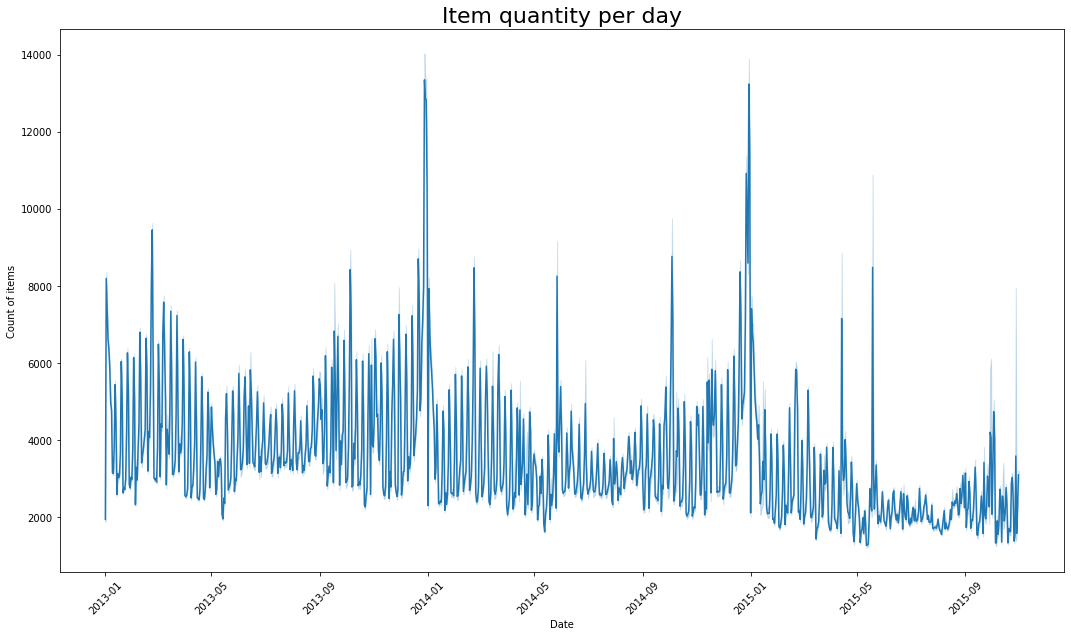

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item quantity per day', fontsize=22)
ax = sns.lineplot(x='date', y="item_cnt_day", data=train, estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items')
plt.xticks(rotation=45)
plt.show()

Seems that there is some seasonality pattern.

In [ ]:
# train["year"] = train.date.dt.year
# train["month"] = train.date.dt.month

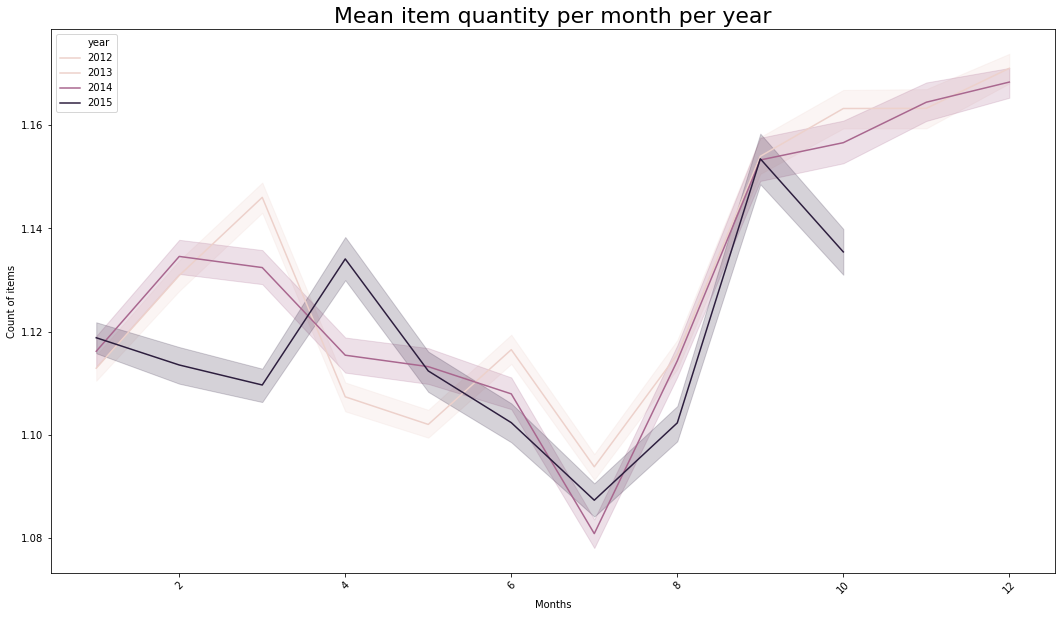

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Mean item quantity per month per year', fontsize=22)
ax = sns.lineplot(x='month', y="item_cnt_day", hue="year", data=train, estimator=np.mean)
ax = ax.set(xlabel='Months', ylabel='Count of items')
plt.xticks(rotation=45)
plt.show()


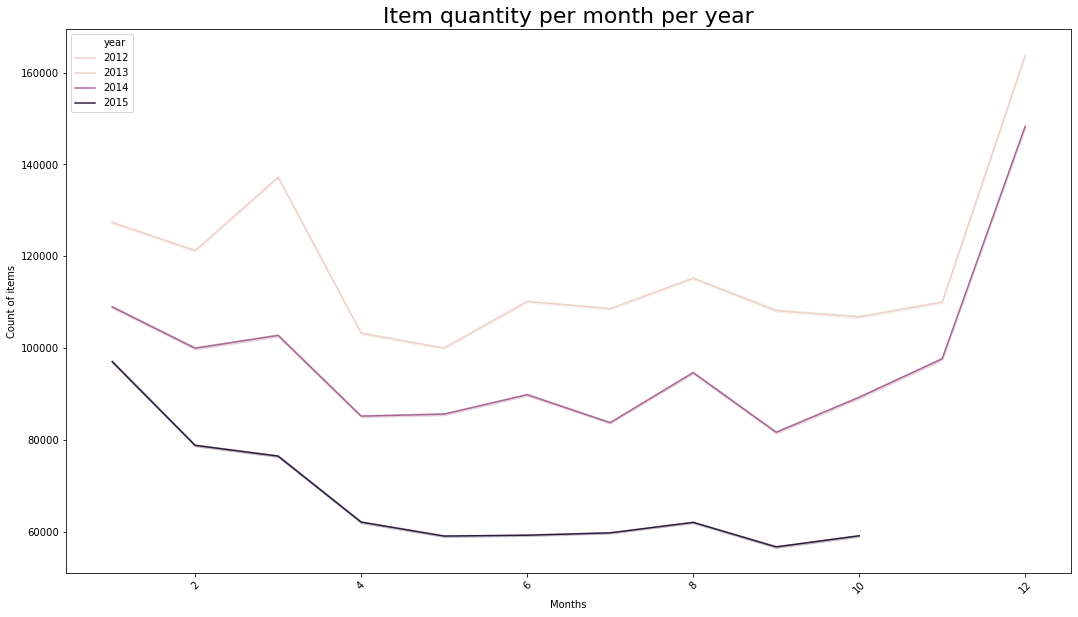

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item quantity per month per year', fontsize=22)
ax = sns.lineplot(x='month', y="item_cnt_day", hue="year", data=train, estimator=np.sum)
ax = ax.set(xlabel='Months', ylabel='Count of items')
plt.xticks(rotation=45)
plt.show()

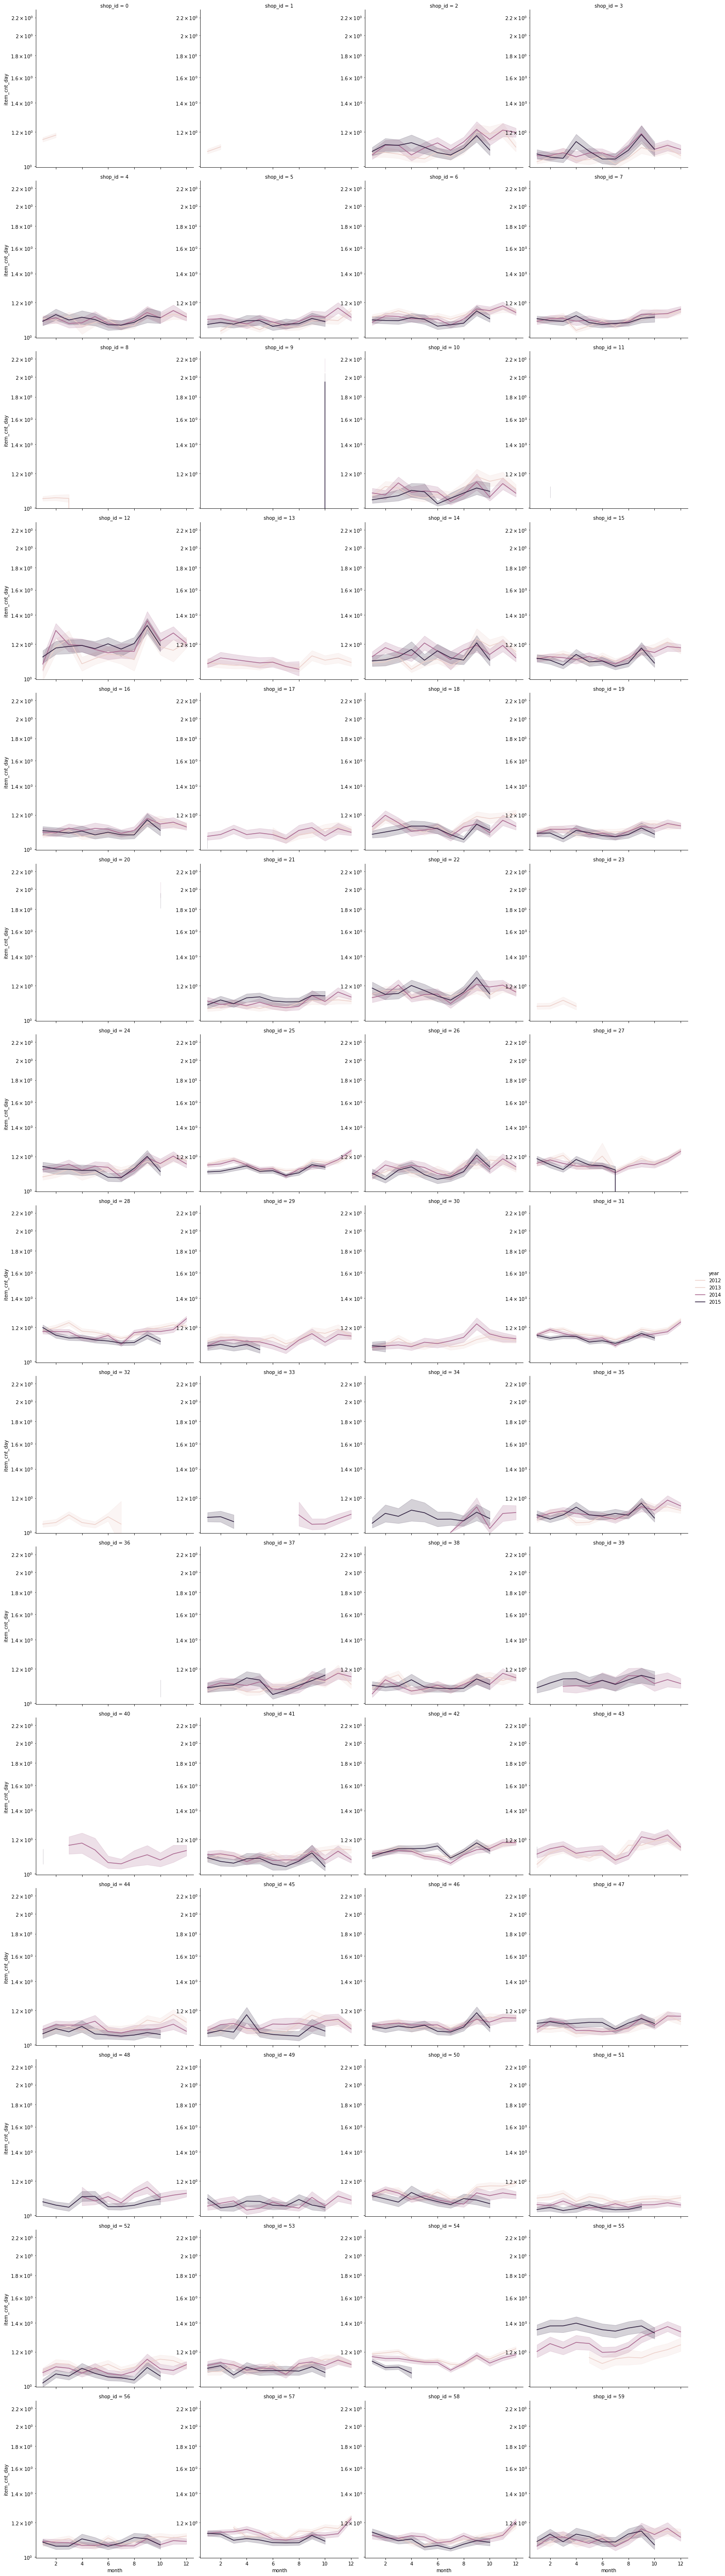

In [ ]:
# Mean Item Quantity Per Month Per Year

g = sns.relplot(x="month",
                y="item_cnt_day",
                kind="line",
                hue="year",
                col="shop_id",
                col_wrap=4,
                data=train,
                estimator="mean")

plt.yscale("log")

In [18]:
def plot_missing_values_heatmap(df: pd.DataFrame) -> None:
  sns.heatmap(df.isnull(), cbar=False, cmap='coolwarm', yticklabels=False)
  plt.title('Missing value in the dataset');


def get_mean_na_part(df: pd.DataFrame):
  return round((df.isna().sum() / df.shape[0]).mean(), 4)

EPSILON = 1e-10
def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted

def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error

    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)

def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))



def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))

def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))

In [19]:
train['year_month'] = train['date'].astype('datetime64[M]')

In [20]:
train

date  date_block_num  ...  item_category_id  year_month
0       2013-01-02               0  ...                37  2013-01-01
1       2013-01-23               0  ...                37  2013-01-01
2       2013-01-20               0  ...                37  2013-01-01
3       2013-01-02               0  ...                37  2013-01-01
4       2013-01-03               0  ...                37  2013-01-01
...            ...             ...  ...               ...         ...
2935844 2015-10-17              33  ...                40  2015-10-01
2935845 2015-10-01              33  ...                15  2015-10-01
2935846 2015-10-29              33  ...                64  2015-10-01
2935847 2015-10-22              33  ...                64  2015-10-01
2935848 2015-10-01              33  ...                64  2015-10-01

[2935849 rows x 8 columns]

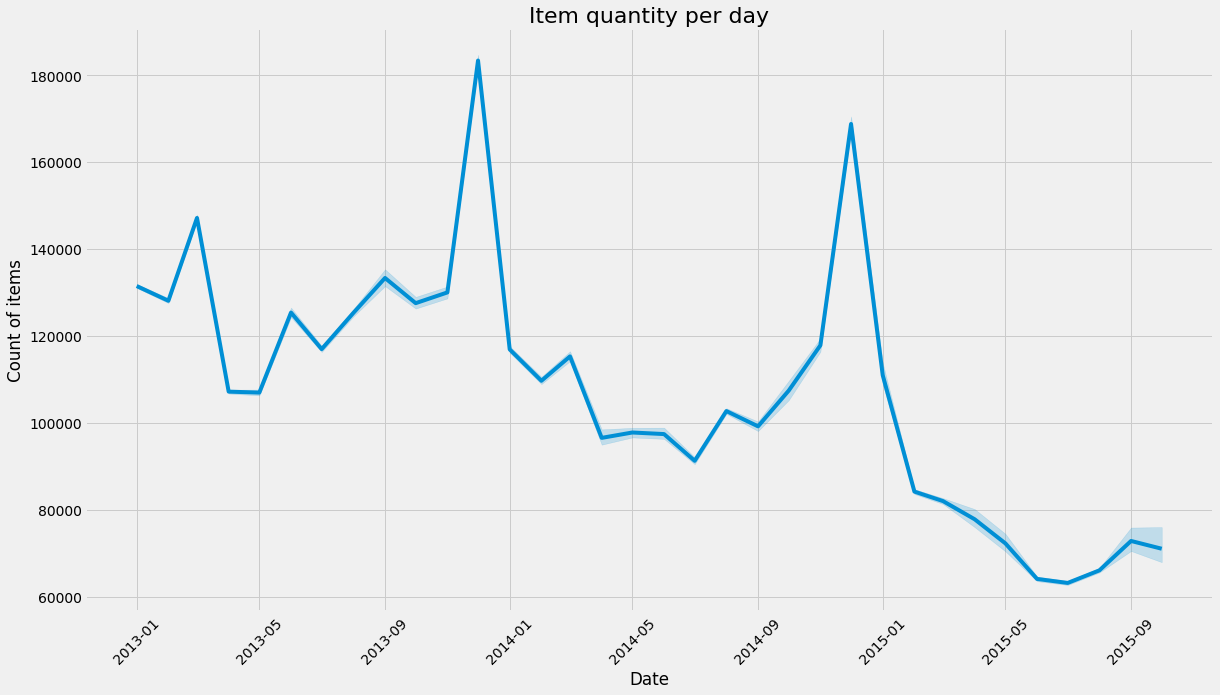

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item quantity per day', fontsize=22)
ax = sns.lineplot(x='year_month', y="item_cnt_day", data=train, estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items')
plt.xticks(rotation=45)
plt.show()

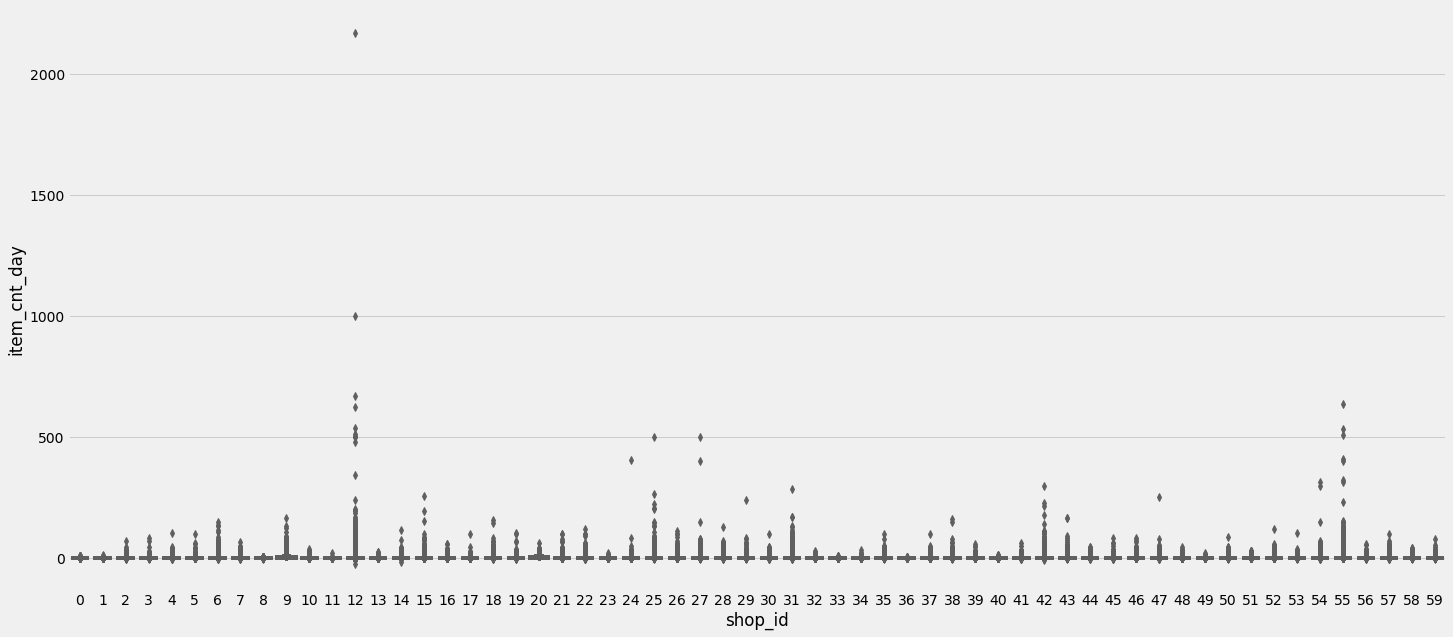

In [ ]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
sns.boxplot(data=train, x='shop_id', y='item_cnt_day',palette="Set3")

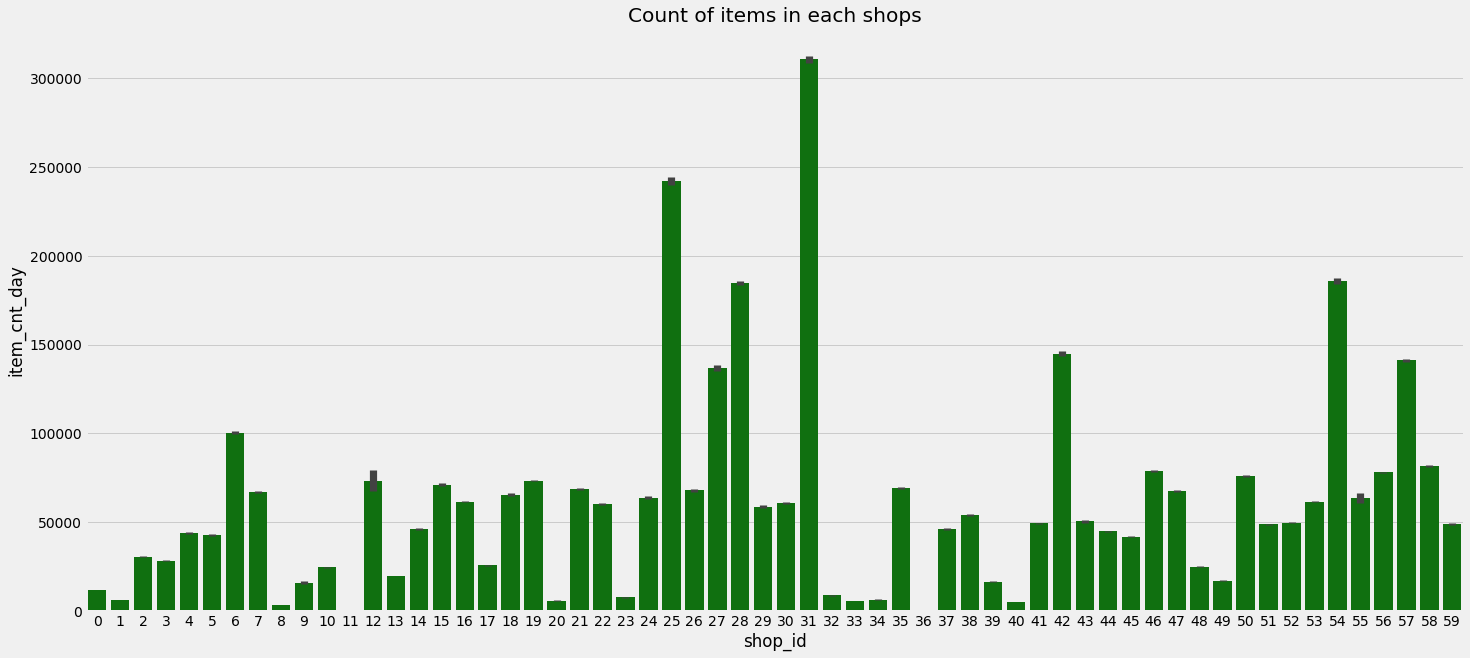

In [ ]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
ax = sns.barplot(x="shop_id", y="item_cnt_day", data=train, estimator=np.sum, color='g').set_title("Count of items in each shops")
plt.show()


# Missing values

In [ ]:
train_super_id_sales_items = train[['shop_id','item_category_id', 'item_id', 'year_month', 'item_cnt_day']].groupby(['shop_id','item_category_id', 'item_id', 'year_month']).sum()
train_super_id_prices_items = train[['shop_id','item_category_id', 'item_id', 'year_month', 'item_price']].groupby(['shop_id','item_category_id', 'item_id', 'year_month']).sum()

train_super_id_sales_items = train_super_id_sales_items.unstack('year_month', fill_value=np.nan)
train_super_id_prices_items = train_super_id_prices_items.unstack('year_month', fill_value=np.nan)

In [ ]:
get_mean_na_part(train_super_id_sales_items), get_mean_na_part(train_super_id_prices_items)

In [ ]:
train_super_id_sales_category = train[['shop_id','item_category_id', 'year_month', 'item_cnt_day']].groupby(['shop_id','item_category_id', 'year_month']).sum()
train_super_id_prices_category = train[['shop_id','item_category_id',  'year_month', 'item_price']].groupby(['shop_id','item_category_id', 'year_month']).sum()

train_super_id_sales_category = train_super_id_sales_category.unstack('year_month', fill_value=np.nan)
train_super_id_prices_category = train_super_id_prices_category.unstack('year_month', fill_value=np.nan)

In [ ]:
get_mean_na_part(train_super_id_sales_category), get_mean_na_part(train_super_id_prices_category)

(0.4138, 0.4138)

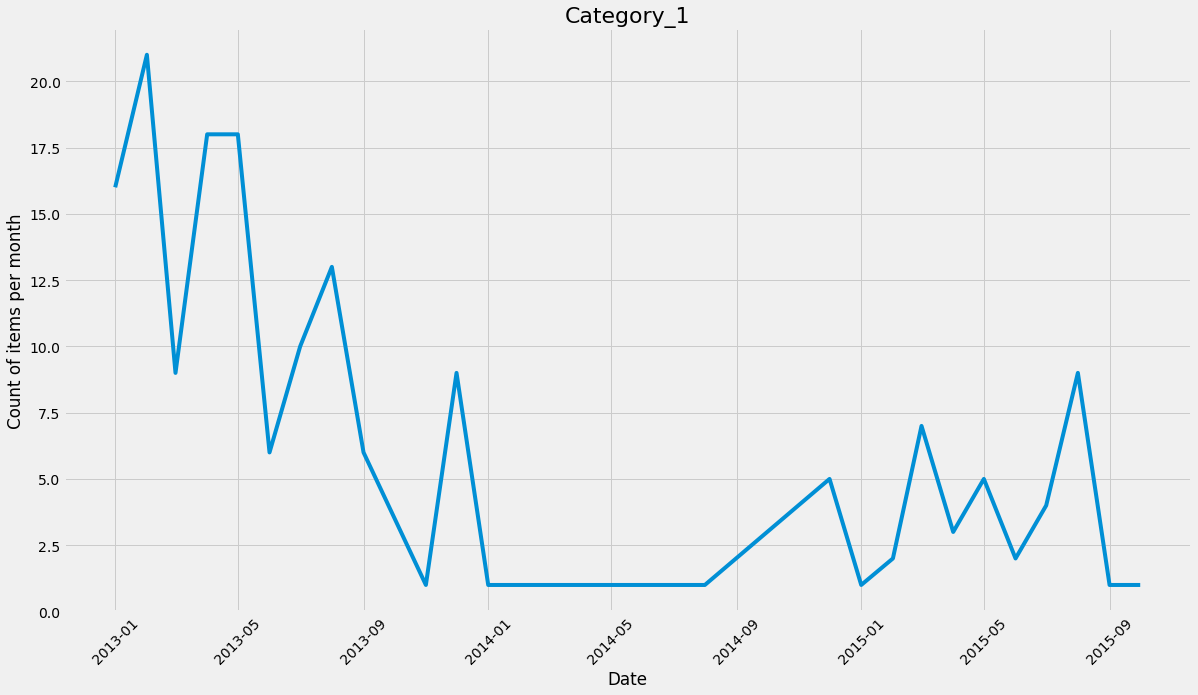

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Category_1', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_category[59][25], data=train_super_id_sales_category[59][25], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

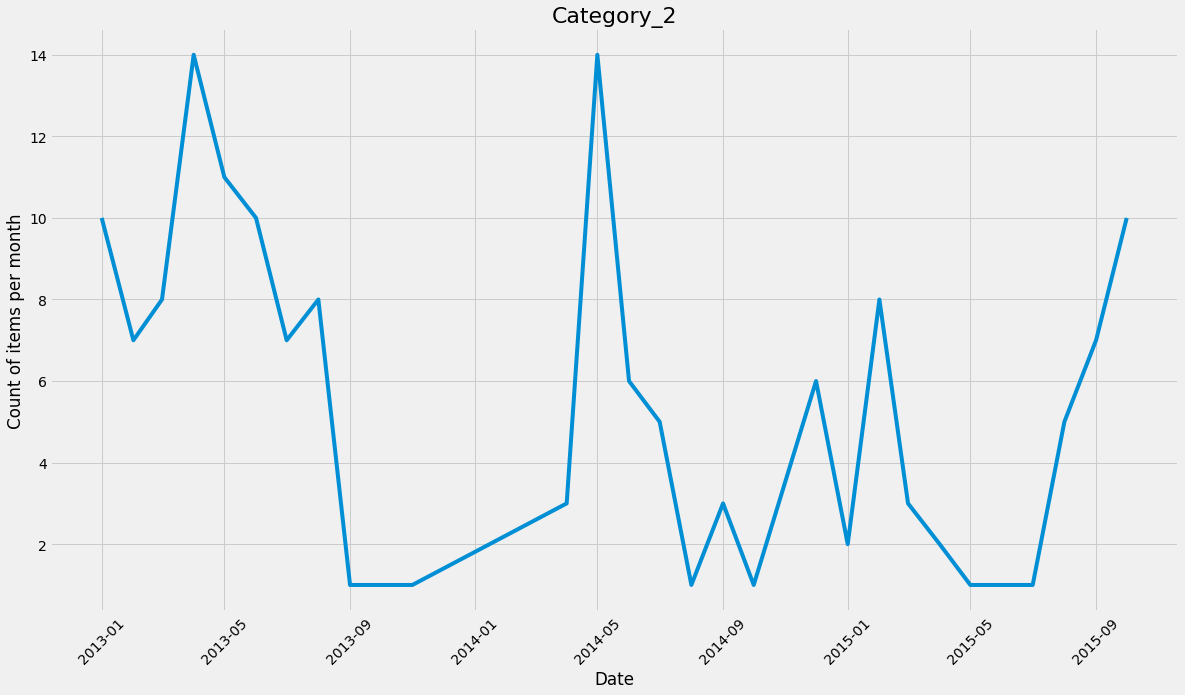

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Category_2', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_category[45][25], data=train_super_id_sales_category[45][25], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

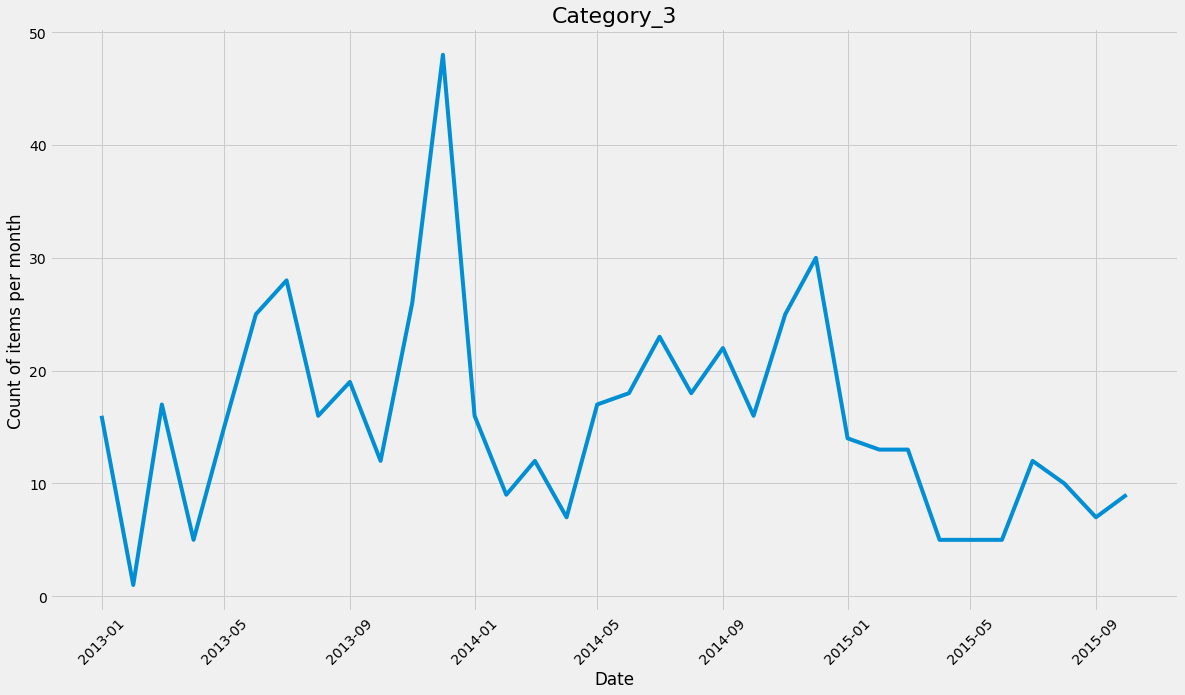

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Category_3', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_category[59][83], data=train_super_id_sales_category[59][83], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

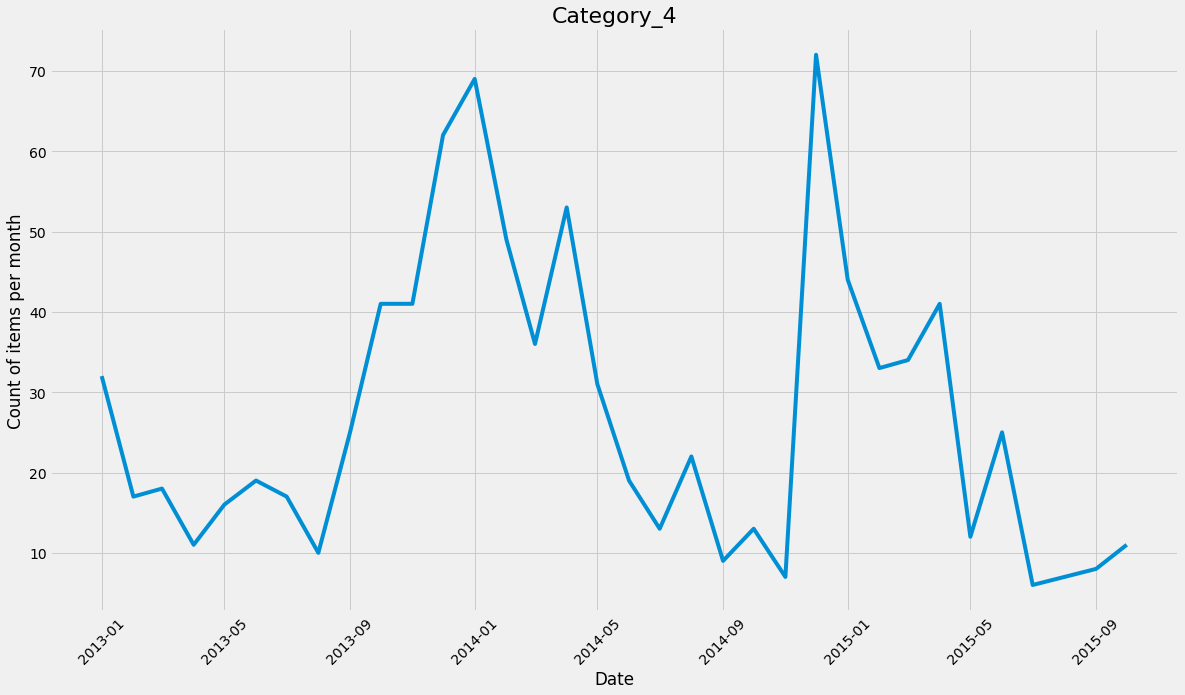

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Category_4', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_category[25][25], data=train_super_id_sales_category[25][25], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

In [ ]:
train_super_id_sales_category.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 34 entries, ('item_cnt_day', Timestamp('2013-01-01 00:00:00')) to ('item_cnt_day', Timestamp('2015-10-01 00:00:00'))
Columns: 3271 entries, (0, 0) to (59, 83)
dtypes: float64(3271)
memory usage: 870.6+ KB


Detalization

In [21]:
train_super_id_sales_shop = train[['shop_id', 'year_month', 'item_cnt_day']].groupby(['shop_id', 'year_month']).sum()

train_super_id_sales_shop = train_super_id_sales_shop.unstack('year_month', fill_value=np.nan)

train_super_id_sales_shop.columns = train_super_id_sales_shop.columns.droplevel()

In [22]:
get_mean_na_part(train_super_id_sales_shop)

0.2225

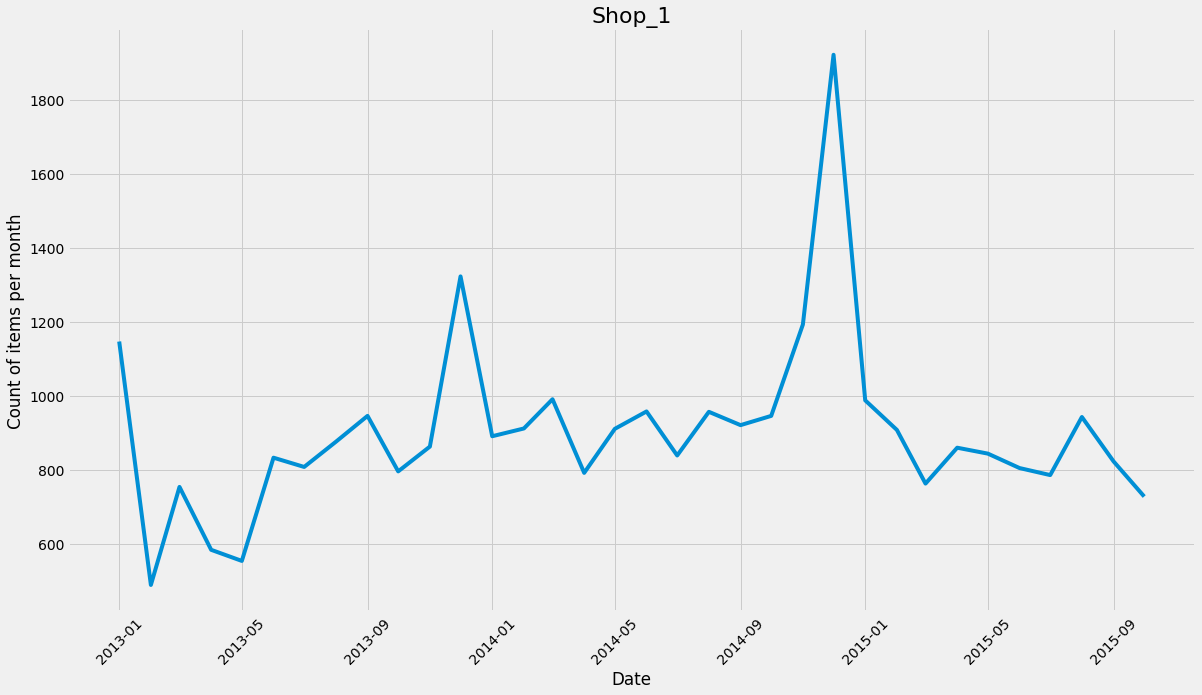

In [23]:
plt.figure(figsize = (18,10))
plt.title('Shop_1', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_shop.T[2], data=train_super_id_sales_shop.T[2], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

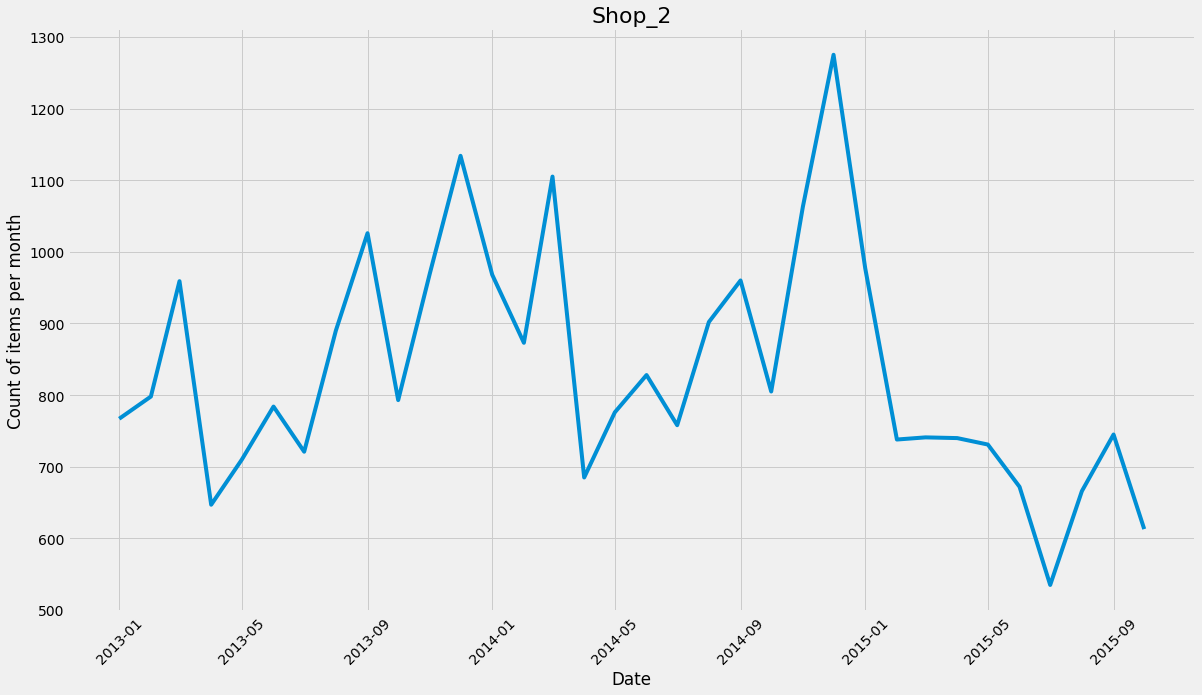

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Shop_2', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_shop.T[3], data=train_super_id_sales_shop.T[3], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

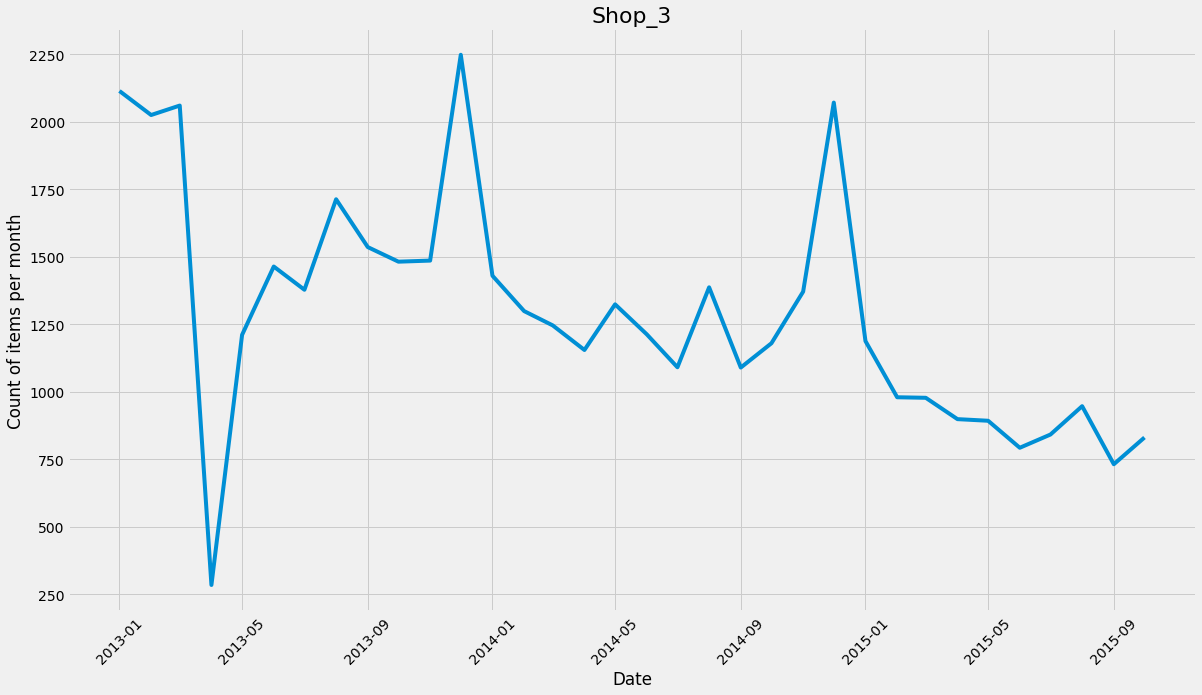

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Shop_3', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_shop.T[4], data=train_super_id_sales_shop.T[4], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

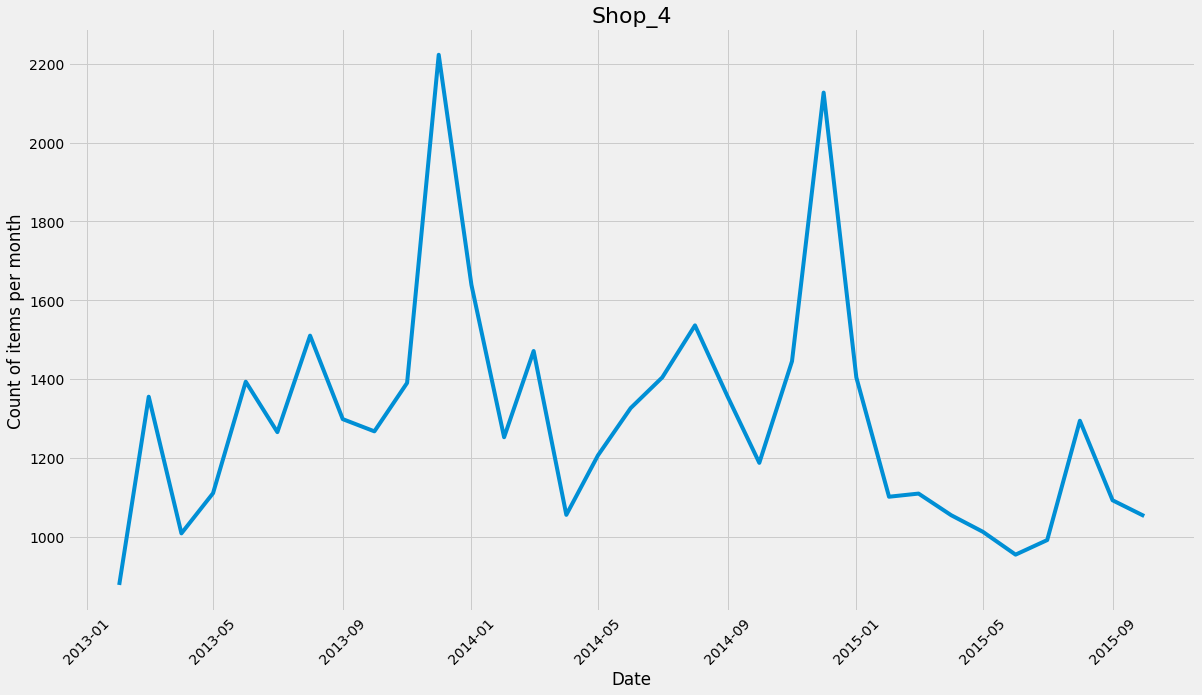

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Shop_4', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_shop.T[5], data=train_super_id_sales_shop.T[5], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

In [24]:
train_super_id_sales_category = train[['shop_id','item_category_id', 'year_month', 'item_cnt_day']].groupby(['shop_id','item_category_id', 'year_month']).sum()

train_super_id_sales_category = train_super_id_sales_category.unstack('year_month', fill_value=np.nan)

train_super_id_sales_category.columns = train_super_id_sales_category.columns.droplevel()

In [25]:
get_mean_na_part(train_super_id_sales_category)

0.4138

In [26]:
train_super_id_sales_items = train[['shop_id','item_category_id', 'item_id', 'year_month', 'item_cnt_day']].groupby(['shop_id','item_category_id', 'item_id', 'year_month']).sum()

train_super_id_sales_items = train_super_id_sales_items.unstack('year_month', fill_value=np.nan)

train_super_id_sales_items.columns = train_super_id_sales_items.columns.droplevel()

In [27]:
get_mean_na_part(train_super_id_sales_items)

0.8884

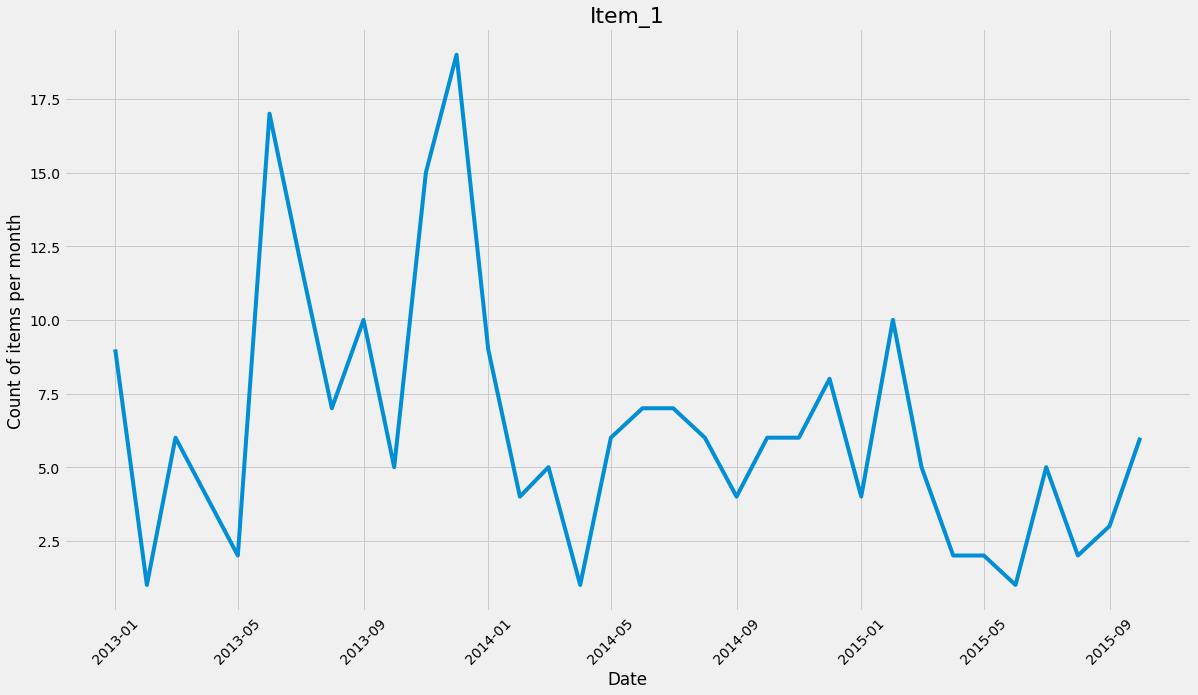

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item_1', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_items.T[59][83][22087], data=train_super_id_sales_items.T[59][83][22087], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

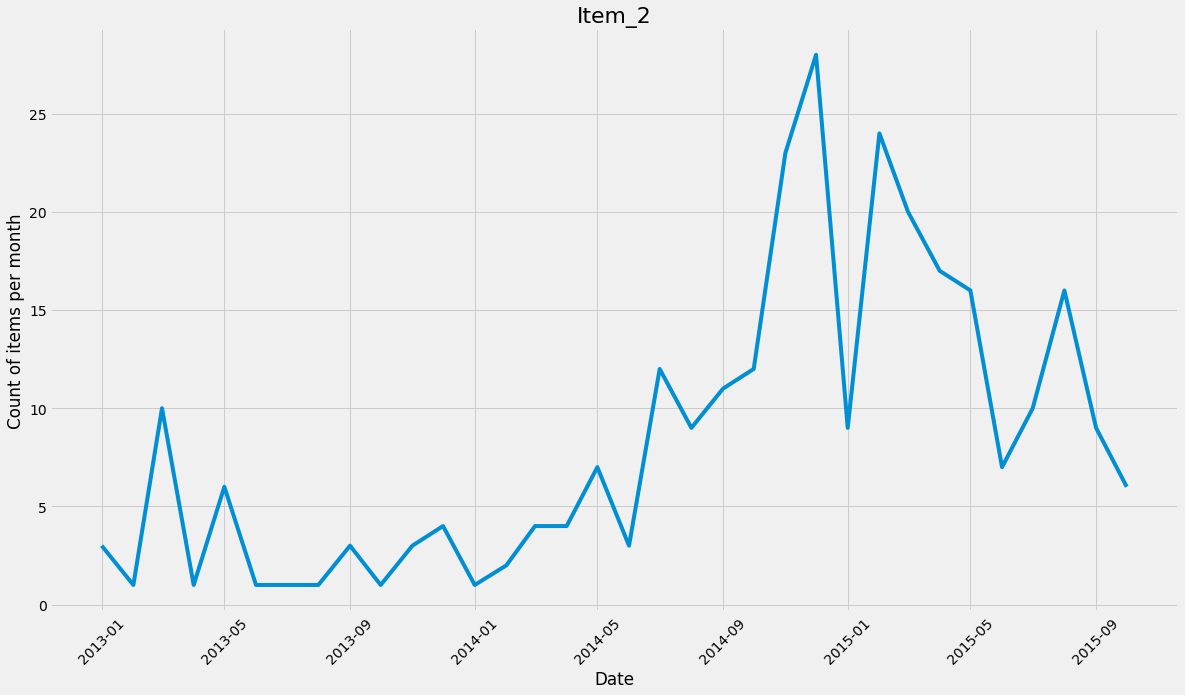

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item_2', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_items.T[18][79][17717], data=train_super_id_sales_items.T[18][79][17717], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

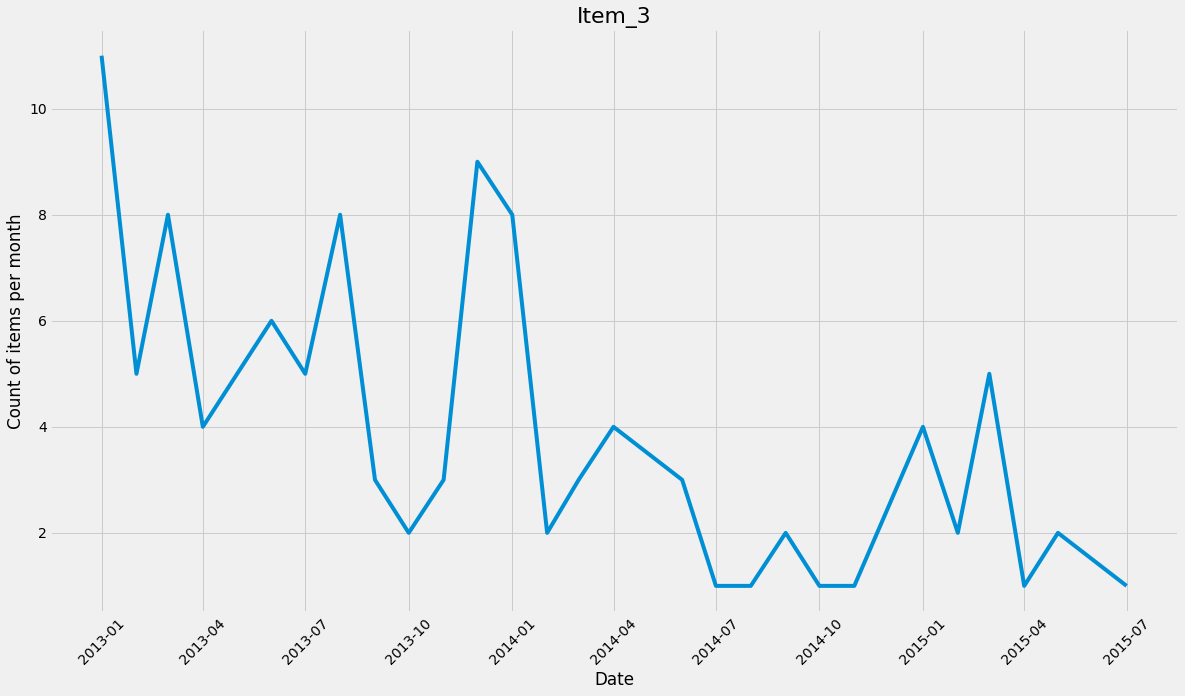

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item_3', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_items.T[28][2][5572], data=train_super_id_sales_items.T[28][2][5572], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

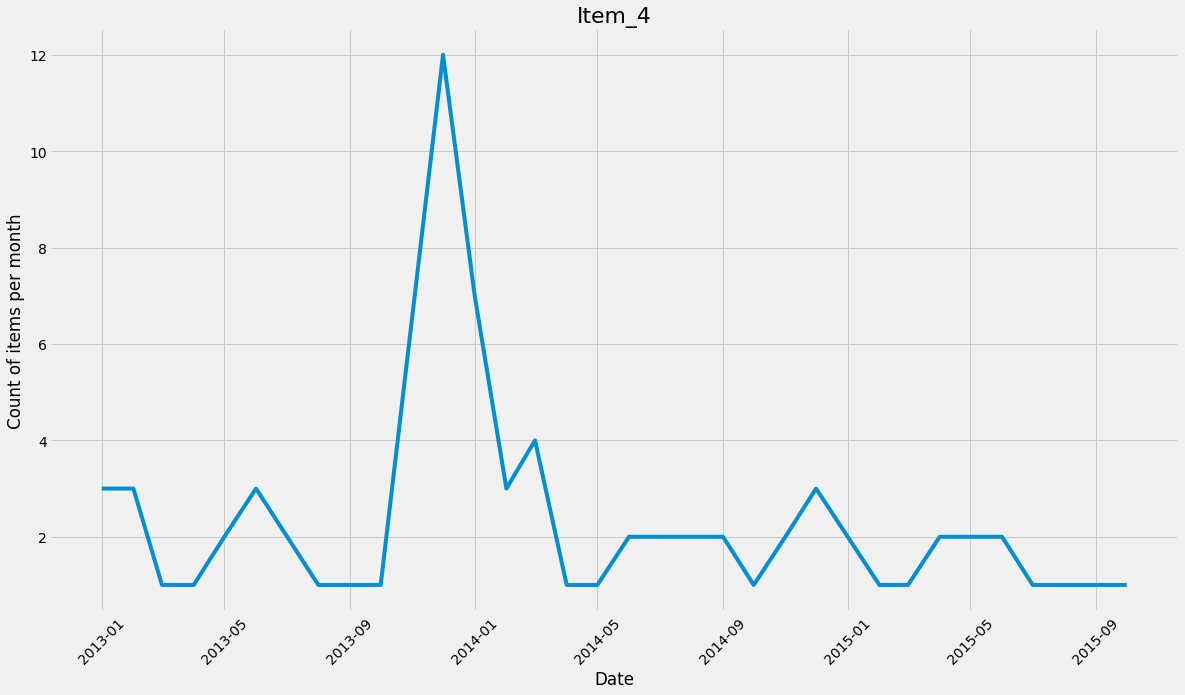

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item_4', fontsize=22)
ax = sns.lineplot(x='year_month', y=train_super_id_sales_items.T[15][2][5643], data=train_super_id_sales_items.T[15][2][5643], estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 


Getting the mean values for each category in each month

In [28]:
train_super_id_sales_items = train_super_id_sales_items.reset_index(level=0, drop=True)
train_super_id_sales_items = train_super_id_sales_items.groupby(['item_category_id']).sum() / train_super_id_sales_items.groupby(['item_category_id']).count()
train_super_id_sales_items = train_super_id_sales_items.fillna(method='ffill').fillna(method='bfill')

Filling in missing values - option 2 

In [29]:
train_super_id_sales_category_FILLED = train_super_id_sales_category.fillna(train_super_id_sales_items)

In [31]:
train_super_id_sales_shop_category_FILLED=train_super_id_sales_category_FILLED.reset_index().drop(columns=['item_category_id']).groupby(['shop_id']).sum()

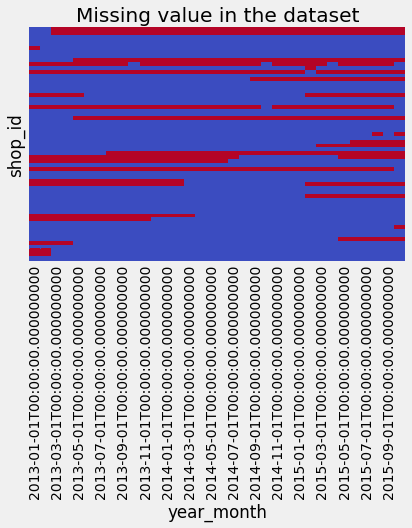

In [34]:
plot_missing_values_heatmap(train_super_id_sales_shop)

In [ ]:
train_super_id_sales_shop.T.values.shape

(34, 60)

In [ ]:
train_super_id_sales_shop.T.isnull().sum()

shop_id
0     32
1     32
2      0
3      0
4      0
5      1
6      0
7      0
8     30
9     30
10     1
11    33
12     0
13    14
14     0
15     0
16     0
17    14
18     0
19     0
20    32
21     0
22     0
23    30
24     0
25     0
26     0
27     2
28     0
29     5
30     8
31     0
32    27
33    25
34    18
35     0
36    33
37     0
38     0
39    14
40    23
41     0
42     0
43     9
44     0
45     0
46     0
47     0
48    15
49    11
50     0
51     1
52     0
53     0
54     6
55     4
56     0
57     2
58     2
59     0
dtype: int64

Filling in missing vlues - option 3

In [36]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(train_super_id_sales_shop.T)
IterativeImputer(random_state=0)
a=imp_mean.transform(train_super_id_sales_shop.T)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [37]:
train_super_id_sales_shop_iterative=pd.DataFrame(a, columns=train_super_id_sales_shop.T.columns)

In [38]:
train_super_id_sales_shop_iterative=round(train_super_id_sales_shop_iterative)

Filling in missing value - option 1

In [ ]:
train_super_id_sales_shop=train_super_id_sales_shop.fillna(round(train_super_id_sales_shop.mean(axis=0)))


# Model 0

In [ ]:
#Option1
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17)
for train_index, test_index in tscv.split(train_super_id_sales_shop.T.values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
    mae_cv.append(mae(np.squeeze(X_test, axis=0).astype(int), X_train[-1].astype(int)))
    rmse_cv.append(rmse(np.squeeze(X_test, axis=0).astype(int), X_train[-1].astype(int)))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [24]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] TEST: [25]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] TEST: [26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 1

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(368.3117647058823, 619.8770277057529)

In [ ]:
#Option2
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17)
for train_index, test_index in tscv.split(train_super_id_sales_shop_category_FILLED.T.values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_super_id_sales_shop_category_FILLED.T.values[train_index], train_super_id_sales_shop_category_FILLED.T.values[test_index]
    mae_cv.append(mae(np.squeeze(X_test, axis=0).astype(int), X_train[-1].astype(int)))
    rmse_cv.append(rmse(np.squeeze(X_test, axis=0).astype(int), X_train[-1].astype(int)))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [24]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] TEST: [25]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] TEST: [26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 1

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(376.77254901960777, 653.0862980314064)

In [ ]:
#Option3
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17)
for train_index, test_index in tscv.split(train_super_id_sales_shop_iterative.values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_super_id_sales_shop_iterative.values[train_index], train_super_id_sales_shop_iterative.values[test_index]
    mae_cv.append(mae(np.squeeze(X_test, axis=0).astype(int), X_train[-1].astype(int)))
    rmse_cv.append(rmse(np.squeeze(X_test, axis=0).astype(int), X_train[-1].astype(int)))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [24]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] TEST: [25]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] TEST: [26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 1

посмотрим средние значения метрики на кросс-валидации:

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(354.9647058823529, 604.2492910843301)

# SimpleExpSmoothing

In [ ]:
#Option1
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop.T.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop.T.columns:
    model = SimpleExpSmoothing(np.asarray(train_super_id_sales_shop.T[i].iloc[train_index])).fit(smoothing_level = 0.8, optimized=False)
    forecast = pd.Series(model.forecast(len(test_index)))
    actual = train_super_id_sales_shop.T[i].iloc[test_index]
    mae_cv.append(mae(actual.values, forecast.values))
    rmse_cv.append(rmse(actual.values, forecast.values))

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(366.1722575415275, 366.1722575415275)

In [ ]:
#Option2
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop_category_FILLED.T.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop_category_FILLED.T.columns:
    model = SimpleExpSmoothing(np.asarray(train_super_id_sales_shop_category_FILLED.T[i].iloc[train_index])).fit(smoothing_level = 0.8, optimized=False)
    forecast = pd.Series(model.forecast(len(test_index)))
    actual = train_super_id_sales_shop_category_FILLED.T[i].iloc[test_index]
    mae_cv.append(mae(actual.values, forecast.values))
    rmse_cv.append(rmse(actual.values, forecast.values))

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(376.69513957236103, 376.69513957236103)

In [ ]:
#Option3
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop_iterative.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop_iterative.columns:
    model = SimpleExpSmoothing(np.asarray(train_super_id_sales_shop_iterative[i].iloc[train_index])).fit(smoothing_level = 0.8, optimized=False)
    forecast = pd.Series(model.forecast(len(test_index)))
    actual = train_super_id_sales_shop_iterative[i].iloc[test_index]
    mae_cv.append(mae(actual.values, forecast.values))
    rmse_cv.append(rmse(actual.values, forecast.values))

In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(349.94882671589386, 349.94882671589386)

# Sarima model

Generation of combinations of seasonal parameters p, q and q

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
#Option1
warnings.filterwarnings("ignore")
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop.T.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop.T.columns:
    for param in pdq:
      for param_seasonal in seasonal_pdq:
        try:
          mod = sm.tsa.statespace.SARIMAX(train_super_id_sales_shop.T[i].iloc[train_index],
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
          results = mod.fit()
          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
          continue

Выходные данные были обрезаны до нескольких последних строк (5000).
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:444.5607350507384
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:239.22680444521123
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:230.69393126959687
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:70.77439589809106
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:430.85738101518166
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:226.69601838845375
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:231.43112034813748
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:69.87508472669865
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:545.0170952495705
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:295.96928604470617
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:298.6835426968979
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:116.89230911783454
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:495.7862417516359
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:270.99743794065273
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:286.7361499795287
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:111.2035227005749
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:457.797

In [ ]:
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop.T.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop.T.columns:
    mod = sm.tsa.statespace.SARIMAX(train_super_id_sales_shop.T[i].iloc[train_index], order=(0, 1, 0), 
                                    seasonal_order=(1, 0, 0, 12), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False)
    results = mod.fit()
    #print(results.summary().tables[1])
    start = len(train_index)
    #end = start + len(test_index) 
    pred = results.get_prediction(start=start, dynamic=False)
    actual = train_super_id_sales_shop.T[i].iloc[test_index]
    forecast = pred.predicted_mean
    mae_cv.append(mae(actual.values, forecast))
    rmse_cv.append(rmse(actual.values, forecast))


In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(316.77616213414996, 316.77616213414996)

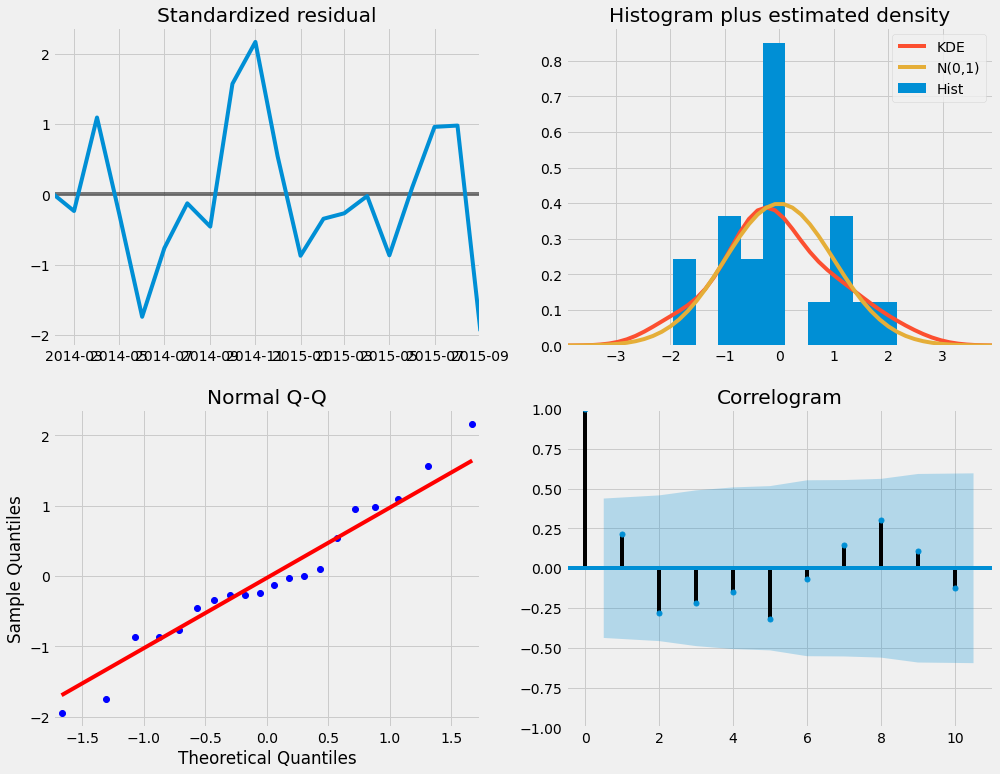

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
#Option2
warnings.filterwarnings("ignore")
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop_category_FILLED.T.values):
  for i in train_super_id_sales_shop_category_FILLED.T.columns:
    for param in pdq:
      for param_seasonal in seasonal_pdq:
        try:
          mod = sm.tsa.statespace.SARIMAX(train_super_id_sales_shop_category_FILLED.T[i].iloc[train_index],
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
          results = mod.fit()
          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
          continue

Выходные данные были обрезаны до нескольких последних строк (5000).
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:418.37228435861863
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:255.9722046653042
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:147.72640405387386
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:34.59974485539475
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:406.2690868805041
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:242.9328422195298
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:144.64181203055742
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:48.733687598053606
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:546.19283459431
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:295.508592030289
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:297.8327345567737
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:116.62817545121005
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:496.69695145241684
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:270.70305743683025
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:286.03556048857075
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:110.75807343780153
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:457.87409

In [ ]:
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop_category_FILLED.T.values):
  for i in train_super_id_sales_shop_category_FILLED.T.columns:
    mod = sm.tsa.statespace.SARIMAX(train_super_id_sales_shop_category_FILLED.T[i].iloc[train_index], order=(0, 1, 0), 
                                    seasonal_order=(0, 1, 0, 12), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False)
    results = mod.fit()
    #print(results.summary().tables[1])
    start = len(train_index)
    #end = start + len(test_index) 
    pred = results.get_prediction(start=start, dynamic=False)
    actual = train_super_id_sales_shop_category_FILLED.T[i].iloc[test_index]
    forecast = pred.predicted_mean
    mae_cv.append(mae(actual.values, forecast))
    rmse_cv.append(rmse(actual.values, forecast))


In [ ]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(334.05769963341254, 334.05769963341254)

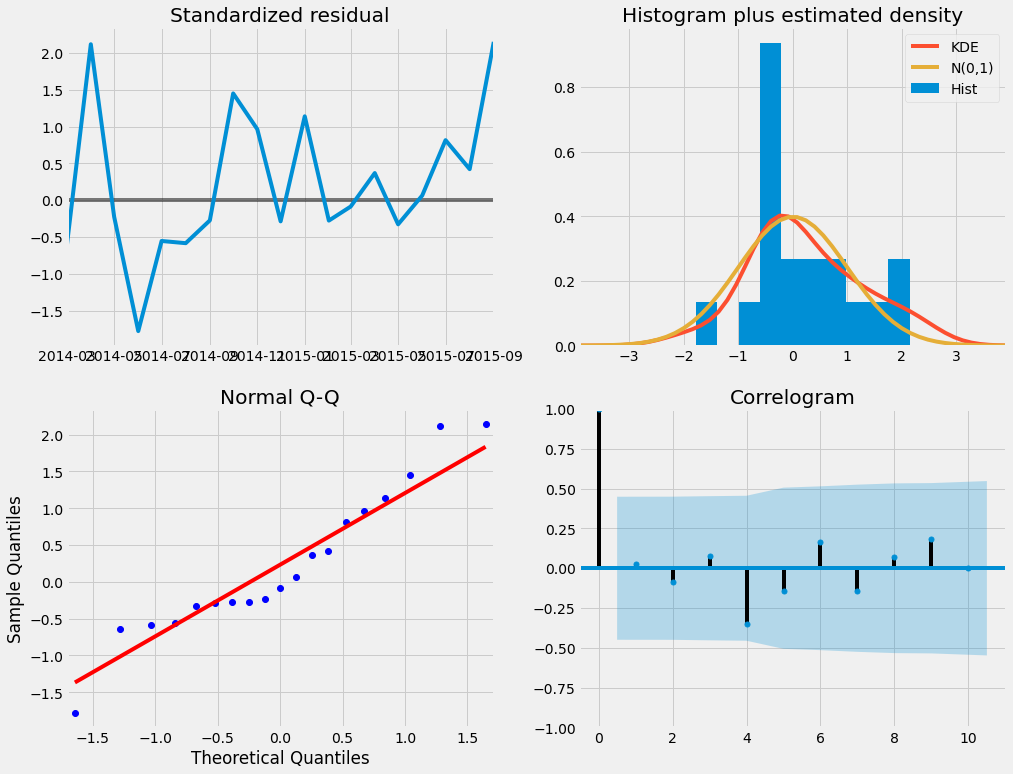

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
#Option3
warnings.filterwarnings("ignore")
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop_iterative.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop_iterative.columns:
    for param in pdq:
      for param_seasonal in seasonal_pdq:
        try:
          mod = sm.tsa.statespace.SARIMAX(train_super_id_sales_shop_iterative[i].iloc[train_index],
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
          results = mod.fit()
          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
          continue

Выходные данные были обрезаны до нескольких последних строк (5000).
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:400.8049697077147
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:207.15260577742748
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:203.76071407649317
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:54.48441120021543
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:386.7760493510759
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:186.42520551260452
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:198.19835528038917
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:56.02927524346365
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:545.0170952495705
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:295.96928604470617
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:298.6835426968979
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:116.89230911783454
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:495.7862417516359
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:270.99743794065273
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:286.7361499795287
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:111.2035227005749
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:457.7971

In [42]:
warnings.filterwarnings("ignore")

In [41]:
mae_cv = list()
rmse_cv = list()
tscv = TimeSeriesSplit(n_splits=17) 
for train_index, test_index in tscv.split(train_super_id_sales_shop_iterative.values):
  #X_train, X_test = train_super_id_sales_shop.T.values[train_index], train_super_id_sales_shop.T.values[test_index]
  for i in train_super_id_sales_shop_iterative.columns:
    mod = sm.tsa.statespace.SARIMAX(train_super_id_sales_shop_iterative[i].iloc[train_index], order=(0, 1, 1), 
                                    seasonal_order=(1, 0, 0, 12), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False)
    results = mod.fit()
    #print(results.summary().tables[1])
    start = len(train_index)
    #end = start + len(test_index) 
    pred = results.get_prediction(start=start, dynamic=False)
    actual = train_super_id_sales_shop_iterative[i].iloc[test_index]
    forecast = pred.predicted_mean
    mae_cv.append(mae(actual.values, forecast))
    rmse_cv.append(rmse(actual.values, forecast))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dis

In [43]:
sum(mae_cv)/len(mae_cv), sum(rmse_cv)/len(rmse_cv)

(299.92777072520755, 299.92777072520755)

In [44]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                 59   No. Observations:                   33
Model:             SARIMAX(0, 1, 1)x(1, 0, 0, 12)   Log Likelihood                -124.315
Date:                            Thu, 29 Apr 2021   AIC                            254.630
Time:                                    12:39:28   BIC                            257.617
Sample:                                         0   HQIC                           255.213
                                             - 33                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4774      0.215      2.225      0.026       0.057       0.898
ar.S.L12       0.5934      0.078   

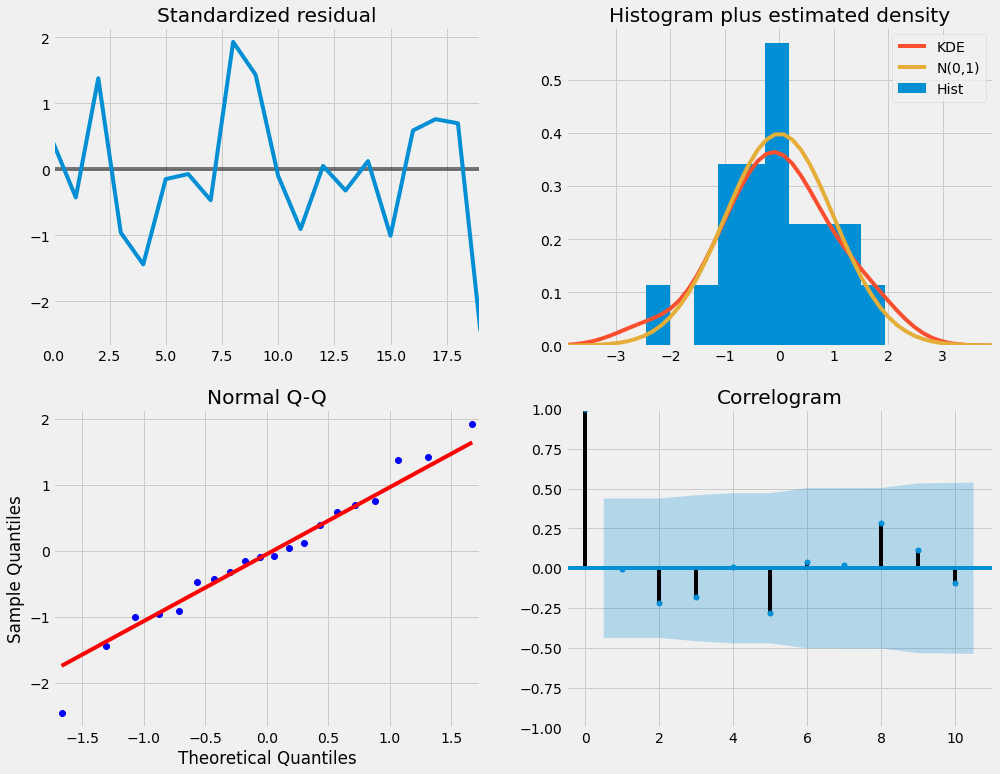

In [45]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
d